In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
from scipy.signal import dfreqresp
from sklearn.model_selection import train_test_split
# from visualize_clf import visualize_clf
from plot3d import plot3d
from test_lr import test_lr
from prepare import prepare_data, preprocess_data

params = {'xtick.labelsize': 18,
'ytick.labelsize': 18,
'axes.titlesize' : 22,
'axes.labelsize' : 20,
'legend.fontsize': 18,
'legend.title_fontsize': 22,
'figure.titlesize': 24 }
pylab.rcParams.update(params)

In [2]:
from verify_gradients import compare_gradients
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from LinearRegressor import LinearRegressor
from sklearn.linear_model import Lasso

## Preliminary: Updated Data Loading

In [3]:

virus_data = pd.read_csv('data_HW3.csv')

raw_train_df, raw_test_df = train_test_split(virus_data, test_size = 0.2, random_state = 134)
raw_train_df, raw_test_df = preprocess_data(raw_train_df), preprocess_data(raw_test_df)

# Prepare training set according to itself
train_df = prepare_data(raw_train_df, raw_train_df)

# Prepare test set according to the raw training set
test_df = prepare_data(raw_train_df, raw_test_df)

## Section 1: Linear regression implementation

In [4]:

sub_train_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 134)
target = 'contamination_level'

# x_train = sub_train_df.filter(regex= '^PCR').to_numpy()
x_train = sub_train_df.drop(columns = [target]).to_numpy()
y_train = sub_train_df['contamination_level']

# x_val = val_df.filter(regex= '^PCR').to_numpy()
x_val = val_df.drop(columns = [target]).to_numpy()
y_val = val_df['contamination_level']

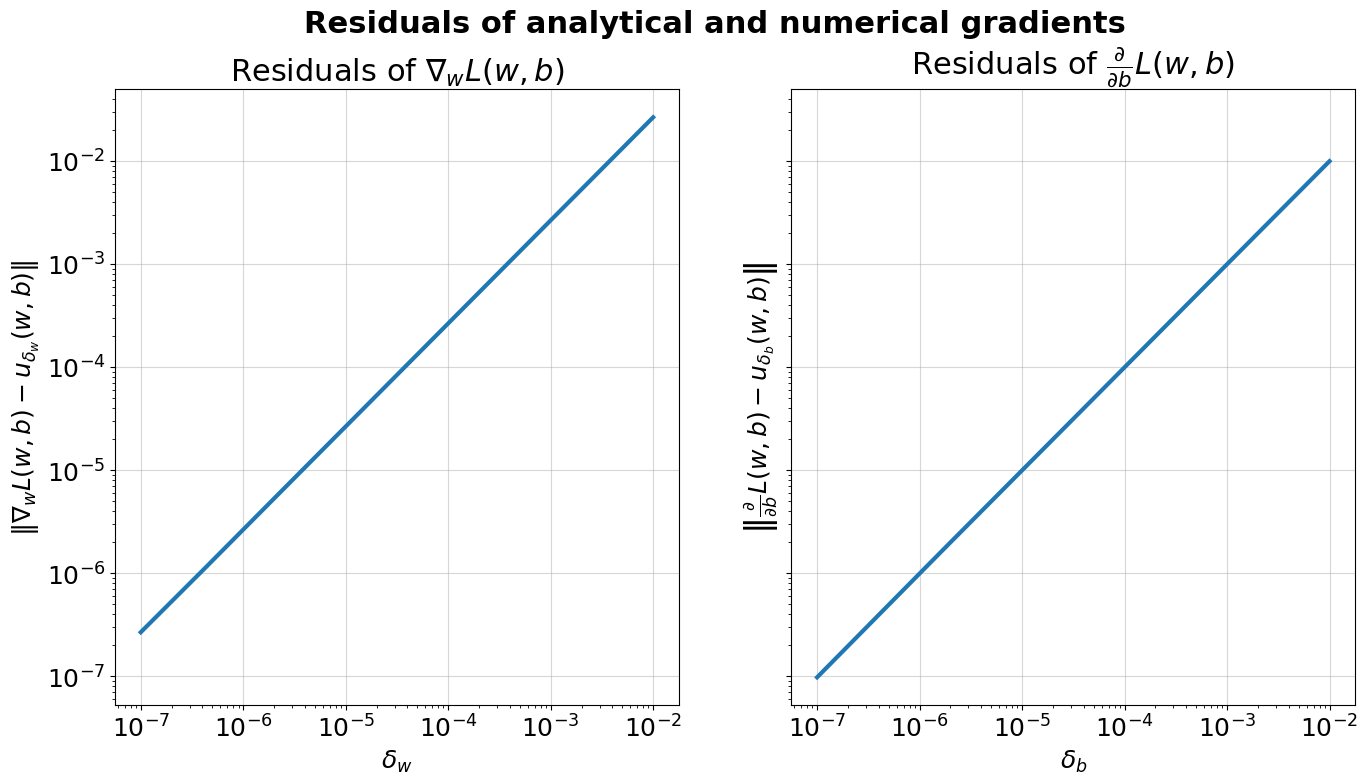

In [5]:
compare_gradients(x_train, y_train, deltas=np.logspace(-7, -2, 9))


lr size = 1e-09, Best train loss = 4.922903722050826, Best validation loss = 4.68652533174686
lr size = 1e-08, Best train loss = 4.922839063001493, Best validation loss = 4.686464719909683
lr size = 1e-07, Best train loss = 4.9221926631282455, Best validation loss = 4.685858785007732
lr size = 1e-06, Best train loss = 4.91574768839275, Best validation loss = 4.6798177459917625
lr size = 1e-05, Best train loss = 4.853162893570046, Best validation loss = 4.621201928156755
lr size = 0.0001, Best train loss = 4.3813898349908404, Best validation loss = 4.182978356334747
lr size = 0.001, Best train loss = 3.701909793623218, Best validation loss = 3.5983085803853725
lr size = 0.01, Best train loss = 3.6883107087469233, Best validation loss = 3.5735792943479674
lr size = 0.1, Best train loss = 3.6945242084616683, Best validation loss = 3.555673935715997


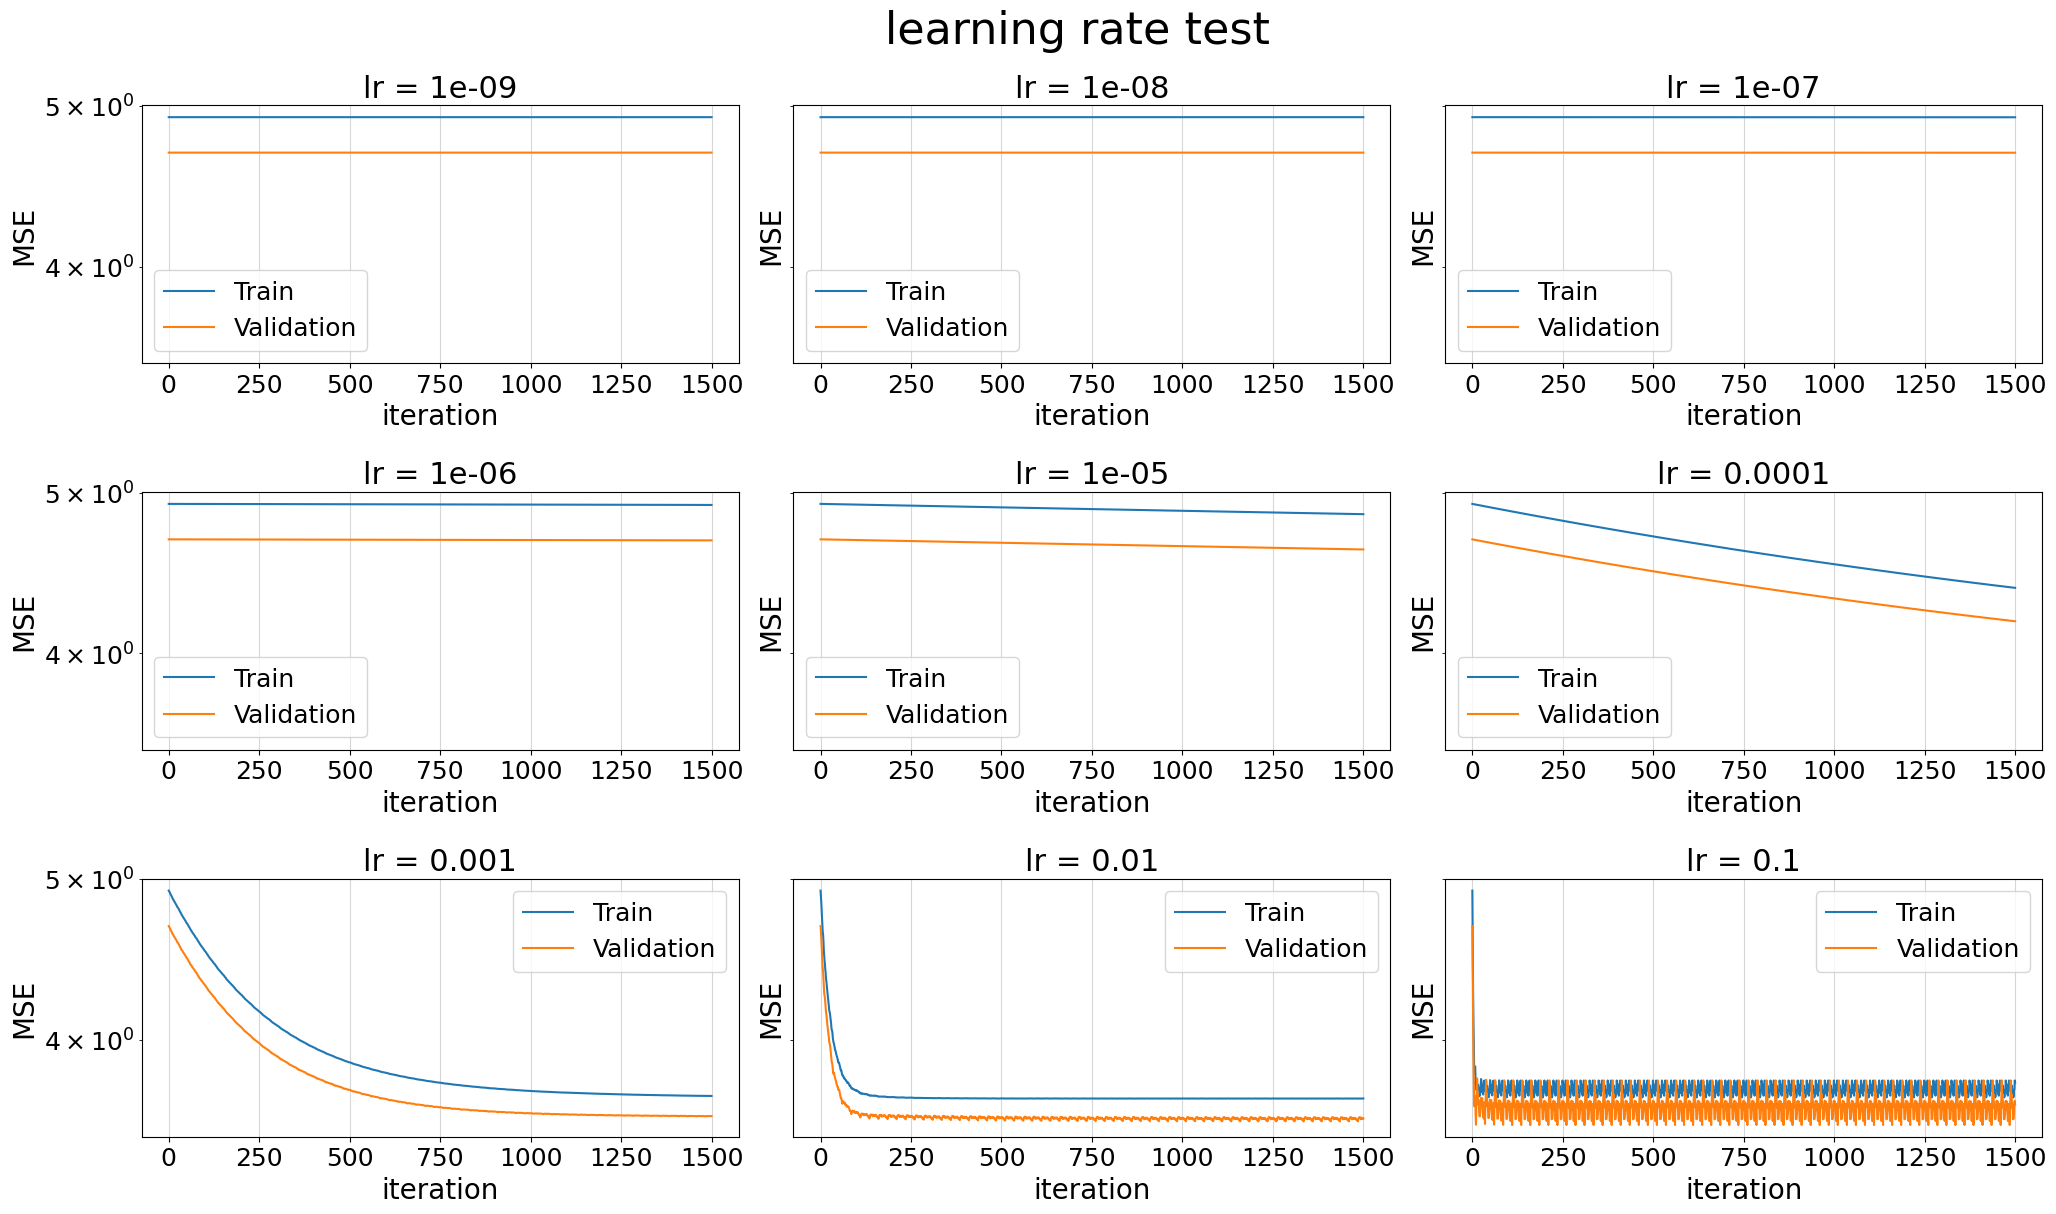

In [6]:
test_lr(x_train, y_train, x_val, y_val, title= 'learning rate test')

## Section 2: Evaluation and Baseline

In [7]:

x_train = train_df.filter(regex= '^PCR').to_numpy()
# x_train = train_df.to_numpy()
y_train = train_df['contamination_level']

x_test = test_df.filter(regex= '^PCR').to_numpy()
# x_test = test_df.to_numpy()
y_test = test_df['contamination_level']

In [8]:
dummy_regr = DummyRegressor(strategy="mean")

result = cross_validate(dummy_regr, x_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
# result = cross_validate(dummy_regr, x_train, y_train, cv=5, scoring='r2', return_train_score=True)

train_score = np.mean(result['train_score'])
val_score = np.mean(result['test_score'])

print(f"Train score: {train_score}")
print(f"Val score: {val_score}")

dummy_validation_score = val_score




Train score: -3.7273901679144807
Val score: -3.738034830111405


In [9]:
fitted_dummy = dummy_regr.fit(x_train, y_train)

#### Basic hyperparameter tuning

In [10]:
values = np.logspace(-9, -1, 9)

train_scores =[]
validation_scores = []
max_score = dict(lr=0,train_score=0, max_validation_score=-100)
dummy_val_scores = np.ones(len(values)) * dummy_validation_score

for lr in values:
    model = LinearRegressor(lr = lr)

    result = cross_validate(model, x_train, y_train, cv= 5, scoring= 'neg_mean_squared_error' ,return_train_score= True)
    train_score = np.mean(result['train_score'])
    validation_score = np.mean(result['test_score'])

    train_scores.append(train_score)
    validation_scores.append(validation_score)


    if validation_score > max_score['max_validation_score']:
        max_score['lr'] = lr
        max_score['train_score'] = train_score
        max_score['max_validation_score'] = validation_score

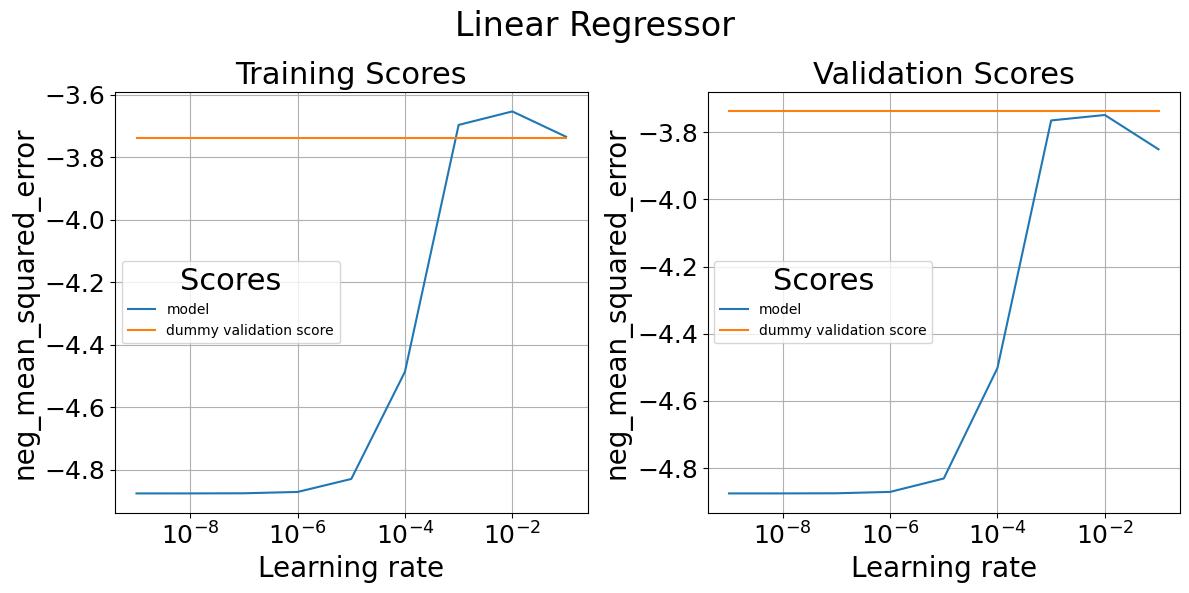

In [11]:

fig, ax = plt.subplots(1,2, figsize=(12, 6))  # Create two subplots stacked vertically

fig.suptitle('Linear Regressor', fontsize=24)
ax[0].semilogx(values, train_scores, label='model')
ax[0].semilogx(values, dummy_val_scores, label='dummy validation score')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('neg_mean_squared_error')
ax[0].set_title('Training Scores')
ax[0].grid(True)
ax[0].legend(fontsize=10, title='Scores')

ax[1].semilogx(values, validation_scores, label='model')
ax[1].semilogx(values, dummy_val_scores, label='dummy validation score')
ax[1].set_xlabel('Learning rate')
ax[1].set_ylabel('neg_mean_squared_error')
ax[1].set_title('Validation Scores')
ax[1].grid(True)
ax[1].legend(fontsize=10, title='Scores')

plt.tight_layout()
plt.show()


In [12]:
print(max_score)

{'lr': 0.01, 'train_score': -3.6527730000959204, 'max_validation_score': -3.748633013045775}


In [13]:
fitted_linear = LinearRegressor(lr = max_score['lr']).fit(x_train, y_train)

In [14]:
test_score = fitted_linear.score(x_test, y_test)

## Section 3: Lasso linear regression


In [15]:

values = np.logspace(-9, 0, 10)

train_scores =[]
validation_scores = []
max_score = dict(lr=0,train_score=0, max_validation_score=-100)
dummy_val_scores = np.ones(len(values)) * dummy_validation_score

for reg in values:
    model = Lasso(alpha= reg, fit_intercept= True)

    result = cross_validate(model, x_train, y_train, cv= 5, scoring= 'neg_mean_squared_error' ,return_train_score= True)
    train_score = np.mean(result['train_score'])
    validation_score = np.mean(result['test_score'])

    train_scores.append(train_score)
    validation_scores.append(validation_score)


    if validation_score > max_score['max_validation_score']:
        max_score['lr'] = lr
        max_score['train_score'] = train_score
        max_score['max_validation_score'] = validation_score

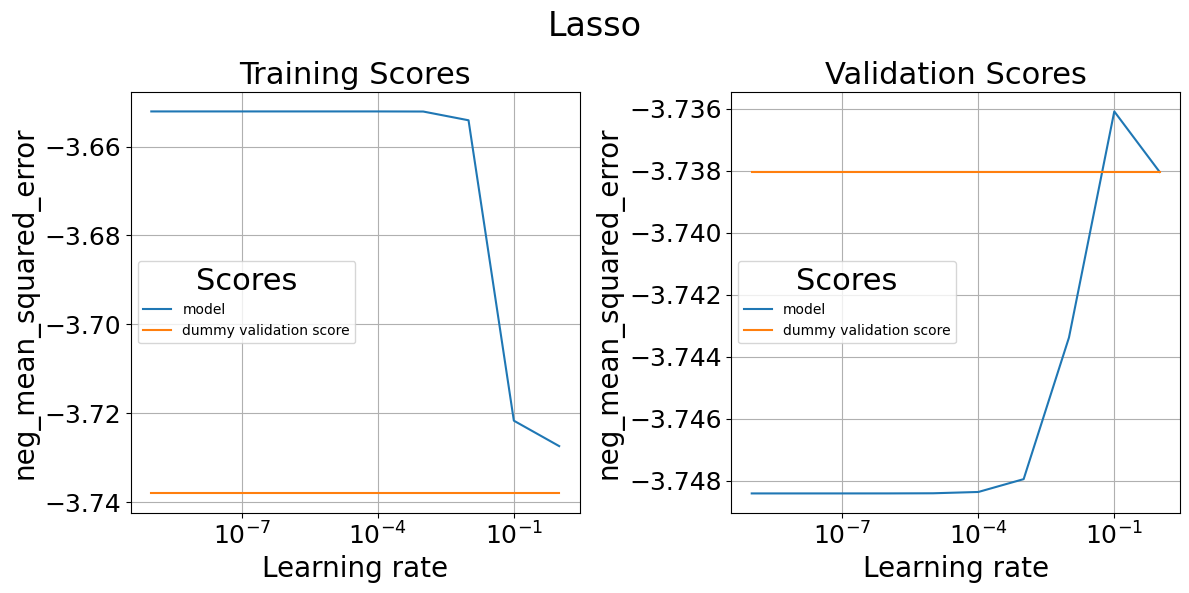

In [16]:

fig, ax = plt.subplots(1,2, figsize=(12, 6))  # Create two subplots stacked vertically

fig.suptitle('Lasso', fontsize=24)
ax[0].semilogx(values, train_scores, label='model')
ax[0].semilogx(values, dummy_val_scores, label='dummy validation score')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('neg_mean_squared_error')
ax[0].set_title('Training Scores')
ax[0].grid(True)
ax[0].legend(fontsize=10, title='Scores')

ax[1].semilogx(values, validation_scores, label='model')
ax[1].semilogx(values, dummy_val_scores, label='dummy validation score')
ax[1].set_xlabel('Learning rate')
ax[1].set_ylabel('neg_mean_squared_error')
ax[1].set_title('Validation Scores')
ax[1].grid(True)
ax[1].legend(fontsize=10, title='Scores')

plt.tight_layout()
plt.show()

In [17]:
print(max_score)

{'lr': 0.1, 'train_score': -3.721668941628663, 'max_validation_score': -3.7360817604841237}


In [18]:
fitted_lasso = Lasso(alpha= max_score['lr'], fit_intercept= True).fit(x_train, y_train)

In [19]:
print(np.sort(fitted_lasso.coef_))

[-0.          0.         -0.         -0.          0.         -0.
 -0.          0.          0.          0.01175686]
